In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
import imageio
from datetime import datetime
from tqdm import tqdm
from coinbase.wallet.client import Client

from dotenv import load_dotenv

load_dotenv('./data/.env')
client = Client(os.environ['COINBASE_KEY'], os.environ['COINBASE_SECRET'])

In [3]:
# load dataset into pandas
pd_bayc = pd.read_csv("./data/collated/bayc.csv")

# load the balances.
pd_bayc_balances = pd.read_csv("./data/balances/bayc.csv")

In [58]:

# code below to color the nodes based on account value and use the size for the number of trades.

# build a heat map for the values of the accounts.
# color_lookup = {v:k['value'] for v, k in graph.nodes.data()}
# low, *_, high = sorted(color_lookup.values())
# norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
# mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cool)
# # map everything according to the defined scale except the 0x0 address node.
# color_lookup['0x0000000000000000000000000000000000000000'] = -1
# null_mapper = ['white' if i == -1 else mapper.to_rgba(i) for i in color_lookup.values()]        

# # we want to treat the zero address 0x0 differently, since otherwise it would be huge. the number 10 is just a constant amount here, so that the point is not too small.
# nx.set_node_attributes(graph, {'0x0000000000000000000000000000000000000000':10}, 'trades')

# # map the number of trades to the size of the nodes
# size_lookup = {v:k['trades'] for v, k in graph.nodes.data()}

# draw the graph
%matplotlib inline
def draw_network_file(graph, filename, date, dataset, pos):
    
    if pos:
        # if we already have some nodes, we want to keep the positions of these nodes.
        pos = nx.spring_layout(graph, pos=pos)
    else:
        pos = nx.spring_layout(graph)

    # get the weights for drawing the width of the edges
    widths = nx.get_edge_attributes(graph, 'weight')

    # build a heat map for the number of trades of the accounts.
    # we need to treat the 0x0 address a bit differently.
    nx.set_node_attributes(graph, {'0x0000000000000000000000000000000000000000':-1}, 'trades')
    color_lookup = { v:k['trades'] for v, k in graph.nodes.data()}
    low, *_, high = sorted(color_lookup.values())
    norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis)
    # map everything according to the defined scale except the 0x0 address node, which is just white.
    null_mapper = ['white' if i == -1 else mapper.to_rgba(i) for i in color_lookup.values()]

    # map the value of a node to it's size. We have a fixed size for the 0x0 node.
    nx.set_node_attributes(graph, {'0x0000000000000000000000000000000000000000':10}, 'value')
    size_lookup = {v:k['value'] for v, k in graph.nodes.data()}

    fig, ax = plt.subplots(figsize=(100, 100))
    ax.set_facecolor("#000000")
    # Visualize graph components
    edges = nx.draw_networkx_edges(graph, pos, alpha=0.3, edge_color="m", width=list(widths.values()))
    nodes = nx.draw_networkx_nodes(graph, pos, node_color=null_mapper, alpha=0.9, node_size=[v * 10 for v in size_lookup.values()])
    
    # add an info box at the top
    textstr = "Project: %s\nDate: %s" % (dataset, date)

    # place a text box in upper left in axes coords
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.75, 0.95, textstr, transform=ax.transAxes, fontsize=70, verticalalignment='top', bbox=props)

    # plt.show()
    # save frame
    plt.savefig(filename)
    plt.close()
    return pos


In [14]:
# function to lookup the value of an account in the dataframe.
def lookupBalanceFromDF(df, block, account):
    value = 0
    try:
        b = df[(df['block']  == block) & (df['address'] == account)]
        value = b['eth_value'].head(1).iat[0]
    except Exception as e:
        print(block,account)
    return value


In [60]:
# First attempt:
# Nodes are the wallets. Size of the nodes is the value of a wallet.
# edges are transactions. Size of the transaction is the amount of eth.
# timescale is one day. we plot the graph after one day.

dataset = "Bored Ape Yacht Club"

# we will use a weighted and directed graph.
graph = nx.DiGraph()
pos = None

plot_interval = 24 * 3600 * 1
start_timestamp = pd_bayc['blk_timestamp'].iloc[0]

# loop over the pandas dataframe.
filenames = []
for row in pd_bayc.itertuples():

    # read the values from the dataframe.
    from_address = row[4].strip()
    to_address = row[5].strip()
    block = row[7]
    timestamp = row[8]
    token_id = row[6]
    eth_value = row[9]

    # make sure both addresses are in the graph.
    if from_address not in graph:
         graph.add_node(from_address)
    if to_address not in graph:
        graph.add_node(to_address)

    # lookup value of both nodes at the time of this block
    value_from = 0
    value_to = 0
    if (not from_address == '0x0000000000000000000000000000000000000000'):
        value_from = lookupBalanceFromDF(pd_bayc_balances, block, from_address)
    if (not to_address == '0x0000000000000000000000000000000000000000'):
        value_to = lookupBalanceFromDF(pd_bayc_balances, block, to_address)

    # set the attributes on this node.
    nx.set_node_attributes(graph, {from_address:value_from, to_address:value_to}, 'value')

    # keep track of how many trades a wallet has done.
    trades = nx.get_node_attributes(graph, "trades")
    if from_address in trades:
        nx.set_node_attributes(graph, {from_address:trades[from_address] + 1}, 'trades')
    else:
        nx.set_node_attributes(graph, {from_address:1}, 'trades')
    if to_address in trades:
        nx.set_node_attributes(graph, {to_address:trades[to_address] + 1}, 'trades')
    else:
        nx.set_node_attributes(graph, {to_address:1}, 'trades')

    # check if this NFT has already been sold and if yes, remove the old sale.
    removeEdges = []
    for (u,v,d) in graph.edges.data():
        if d['token'] == token_id:
            removeEdges.append((u,v))
    # we need to remove them in a seperate step, since otherwise we change the datastructure that we are iterating over.
    for (u,v) in removeEdges:
        graph.remove_edge(u,v)

    # add an edge for the transaction.
    value = eth_value # currently we do not care if it was eth or weth
    graph.add_edge(from_address, to_address, weight=value, token=token_id) # keep track of token id by adding it to the edge.

    if (timestamp - start_timestamp) >= plot_interval:
        # create file name and append it to a list
        filename = f'../tmp/{row[0]}.png'
        filenames.append(filename)
        draw_date = datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d')
        pos = draw_network_file(graph, filename, draw_date, dataset, pos)
        start_timestamp = timestamp

# build gif
with imageio.get_writer('../network.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# remove files
for filename in set(filenames):
    os.remove(filename)

13660814 0xd83c7bced50ba86f1c1fbf29abba278e3659f72a
13660814 0x88341d1a8f672d2780c8dc725902aae72f143b0c
13660862 0xcd4f099782d1c7029f548bde91b4b2ba83bef965
13660862 0xca058756e10e3d1535d2cda04e891ce99f388d5c
13660988 0x82312ff861748b95011a7908aa4a89861a736f2c
13660988 0x0c2a322332a1cb04bca690dee271212be77721ca
13660993 0x82312ff861748b95011a7908aa4a89861a736f2c
13660993 0x0c2a322332a1cb04bca690dee271212be77721ca
13661522 0x160c1e92abead0b18a1326cb43dae456d8086d6e
13661522 0xdc7bfc3058654da90692457f68ee3a34e2dd3908
13661685 0xf2e03bb3bae583d72d750b3ef443372f92cf2c24
13661685 0xf0c55da3a8274f6843434df0da437ed4ac0dd310
13661710 0x4397ccdde83cfdea014d4a23b7818a0af385e25d
13661710 0x5c9e30def85334e587cf36eb07bdd6a72bf1452d
13661765 0xf0c55da3a8274f6843434df0da437ed4ac0dd310
13661765 0x39fec2e2beab6a63c1e763d0dc4120af60bee39f
13661866 0x39fec2e2beab6a63c1e763d0dc4120af60bee39f
13661866 0xceb03035ba74435b773075eea40a04ec95ccea88
13662030 0x74fc5cb7632cc3f9fad7bc2e2f4e2097ff2e1509
13662030 0xc

In [ ]:
# %matplotlib notebook

graph = nx.path_graph(5)

print(graph.nodes)

fig, ax = plt.subplots()
pos = nx.spring_layout(graph)
nodes = nx.draw_networkx_nodes(graph, pos=pos, ax=ax)
edges = nx.draw_networkx_edges(graph, pos=pos, ax=ax)

annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot_edges(ind):
    edge = list(graph.edges)[ind["ind"][0]]
    xy = (pos[edge[0]] + pos[edge[1]])/2
    annot.xy = xy
    node_attr = {'edge': edge}
    node_attr.update(graph.edges[edge])
    text = '\n'.join(f'{k}: {v}' for k, v in node_attr.items())
    annot.set_text(text)

def update_annot_nodes(ind):
    node = ind["ind"][0]
    xy = pos[node]
    annot.xy = xy
    node_attr = {'node': node}
    node_attr.update(graph.nodes[node])
    text = '\n'.join(f'{k}: {v}' for k, v in node_attr.items())
    annot.set_text(text)

def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = edges.contains(event)
        cont2, ind2 = nodes.contains(event)
        if cont:
            update_annot_edges(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        elif cont2:
            update_annot_nodes(ind2)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()

In [4]:
prices = {}
def getETHPrice(date):
    if date in prices:
        return prices[date]
    else:
        prices[date] = client.get_spot_price(currency_pair = 'ETH-USD', date=date)['amount']
        return prices[date]


13660862 0xca058756e10e3d1535d2cda04e891ce99f388d5c
13660988 0x0c2a322332a1cb04bca690dee271212be77721ca
13661522 0xdc7bfc3058654da90692457f68ee3a34e2dd3908
13661710 0x5c9e30def85334e587cf36eb07bdd6a72bf1452d
13662714 0x5bc5da80efddb53cf0d70c3946edf8065ae79281
13663371 0xb86191271792599270c3c1d0cbe17f3cd6deb33e
13664040 0x8c885cf1d63d3b47b4fe4e265afd45744651f45b
13665272 0xda52e7dbd3e6d0debd99dc08c9e4a649397da8d7
13665449 0xd18d8acffe5b52bea989e11d70d70cf8e56f2959
13665630 0x1227184e56cd3d5c2b5cb0d4685ea96316fe7112
13665790 0x0c6885d88c739049e3017c1c9cc3101356581ddb
13666093 0xb329c5d6e031e12c0efcd81c36d5a8e993c957ba
13666115 0x1f683a0012fdb0b35c5248a4ac7f5e56e72fccad
13666542 0x45fa95d4bb1b3c74507a32c785476e739f832d99
13666698 0x1737c7db75ceab1764e146b0b0ba91ee03617fa9
13667168 0xe3b793caf4826e514200f3ab0383d6d8adf3169e
13667200 0xaa3939e4142e2a6b866b9bdb59decf7d578d7811
13667249 0xeb1eb5cfeccc7b0fd539739ca70467c20a5e5646
13667266 0x20022b5c65961ab40eb6e485fa81ba0a15a2bc4b
13667283 0xb

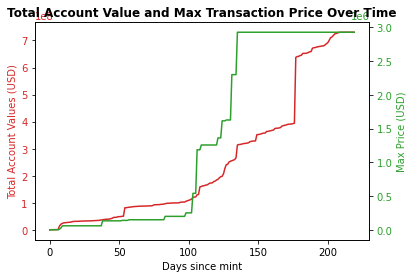

In [26]:
# Ideas to plot:
# Sum of account values vs max price.

def plotTotalAccountValueVsMaxPrice(transactions, balances):
    
    plot_interval = 24 * 3600 * 1 # 1 day
    start_timestamp = pd_bayc['blk_timestamp'].iloc[0]

    # loop over the pandas dataframe.
    accounts_added = []
    totalValue = 0
    valueHistory = []
    maxPrice = 0
    maxPriceHistory = []
    for row in transactions.itertuples():

        # read the values from the dataframe.
        # token_id  blk_timestamp	 eth_value	 weth_value
        from_address = row[4].strip()
        to_address = row[5].strip()
        block = row[7]
        timestamp = row[8]
        token_id = row[6]
        eth_value = row[9]
        date = datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d')

        # lookup value of both nodes at the time of this block and sum up the value of the accounts.
        value_from = 0
        value_to = 0
        if (not from_address == '0x0000000000000000000000000000000000000000' and not from_address in accounts_added):
            value_from = lookupBalanceFromDF(pd_bayc_balances, block, from_address)
            accounts_added.append(from_address)
        if (not to_address == '0x0000000000000000000000000000000000000000' and not to_address in accounts_added):
            value_to = lookupBalanceFromDF(pd_bayc_balances, block, to_address)
            accounts_added.append(to_address)
        
        ethPrice = float(getETHPrice(date))
        totalValue = totalValue + (ethPrice * (value_from + value_to))

        # keep track of the max transaction price.
        newPrice = float(eth_value) * ethPrice
        if newPrice > maxPrice:
            maxPrice = newPrice

        if (timestamp - start_timestamp) >= plot_interval:
            valueHistory.append(totalValue)
            maxPriceHistory.append(maxPrice)
            start_timestamp = timestamp

    # plt.plot(x,valueHistory, color='b')
    # plt.plot(x,maxPriceHistory, color='r')
    # plt.xlabel('Days since mint')
    # plt.ylabel('Value (USD)')
    # 
    # plt.show()

    # finish the data.
    days = len(valueHistory)
    x = np.arange(0, days, 1)

    # Creating plot with dataset_1
    fig, ax1 = plt.subplots() 
  
    color = 'tab:red'
    ax1.set_xlabel('Days since mint') 
    ax1.set_ylabel('Total Account Values (USD)', color = color) 
    ax1.plot(x, valueHistory, color = color) 
    ax1.tick_params(axis ='y', labelcolor = color) 
  
    # Adding Twin Axes to plot using dataset_2
    ax2 = ax1.twinx() 
    
    color = 'tab:green'
    ax2.set_ylabel('Max Price (USD)', color = color) 
    ax2.plot(x, maxPriceHistory, color = color) 
    ax2.tick_params(axis ='y', labelcolor = color) 
  
    # Adding title
    plt.title('Total Account Value and Max Transaction Price Over Time', fontweight ="bold")
    
    # Show plot
    plt.show()
    
pd_bayc = pd.read_csv("./data/collated/bayc.csv")
pd_bayc_balances = pd.read_csv("./data/balances/bayc.csv")
plotTotalAccountValueVsMaxPrice(pd_bayc, pd_bayc_balances)